In [1]:
import os
import sys
import torch
import torch.nn as nn
import torch.optim as optim
from collections import OrderedDict
import numpy as np
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# Add the parent directory to sys.path so local modules can be imported
current_directory = os.path.dirname(os.path.abspath(__file__)) if "__file__" in globals() else os.getcwd()
project_root = os.path.dirname(current_directory)
if project_root not in sys.path:
    sys.path.append(project_root)

import utils as utils
import models as models
import evaluate_model as evaluate_model

import torch
import numpy as np
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

%matplotlib inline

@torch.no_grad()
def collect_features_from_loader(loader, device=None, max_samples=3000, flatten="mean_time"):
    """
    Collect X (features) and y (labels) from a DataLoader.
    Handles (x,y) batches, squeezes T=1, or reduces time by mean/flatten.
    """
    if device is None:
        device = "cuda" if torch.cuda.is_available() else "cpu"

    X_list, y_list = [], []
    n_collected = 0

    for batch in loader:
        # Expect (x, y)
        if isinstance(batch, (list, tuple)) and len(batch) >= 2:
            x, y = batch[0], batch[1]
        elif isinstance(batch, dict) and "x" in batch and "y" in batch:
            x, y = batch["x"], batch["y"]
        else:
            raise ValueError("Batch must be (x, y) or {'x':..., 'y':...}")

        x = x.to(device)

        # Handle shapes:
        # [B, 1, F] -> squeeze time dim
        # [B, T, F] -> reduce by mean over time or flatten
        if x.ndim == 3:
            B, T, F = x.shape
            if T == 1:
                x = x.squeeze(1)                # [B, F]
            else:
                if flatten == "mean_time":
                    x = x.mean(dim=1)           # [B, F]
                elif flatten == "flatten":
                    x = x.reshape(B, T * F)     # [B, T*F]
                else:
                    raise ValueError("flatten must be 'mean_time' or 'flatten'")
        elif x.ndim == 2:
            pass  # already [B, F]
        else:
            # Fallback: flatten everything except batch
            x = x.view(x.shape[0], -1)

        x_np = x.detach().cpu().numpy()

        # Labels to numpy
        if isinstance(y, torch.Tensor):
            y_np = y.detach().cpu().numpy()
        else:
            y_np = np.asarray(y)

        # If one-hot -> argmax
        if y_np.ndim == 2 and y_np.shape[1] > 1:
            y_np = y_np.argmax(axis=1)
        y_np = np.squeeze(y_np)

        X_list.append(x_np)
        y_list.append(y_np)

        n_collected += x_np.shape[0]
        if n_collected >= max_samples:
            break

    if not X_list:
        raise ValueError("No data collected from loader.")

    X = np.vstack(X_list)
    y = np.concatenate(y_list)

    if X.shape[0] > max_samples:
        X = X[:max_samples]
        y = y[:max_samples]

    return X, y




In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

current_directory = os.getcwd()  # /proj/.../Local_IDS/src

project_root = os.path.dirname(current_directory)              # /proj/.../Local_IDS
domains_path = os.path.join(project_root, 'data/attack_data') 


domains = utils.create_domains(domains_path)

train_domains_loader = {}
test_domains_loader = {}
per_domain_results = OrderedDict()


for key, files in domains.items():
    train_domains_loader[key], test_domains_loader[key] = utils.load_data(domains_path, key, files, window_size=10, step_size=3, batch_size=128)


Using device: cuda


In [4]:

# --- Collect features (label=1 only) from multiple domains ---
def collect_features_for_domains(loaders_dict, domain_keys, label_filter=1, device="cpu", max_per_domain=1000):
    """
    Collects features and labels across multiple domains for t-SNE.
    label_filter=1 → select only samples with label == 1
    """
    all_X = []
    all_domain_labels = []

    for domain_idx, domain_key in enumerate(domain_keys):
        X, y = collect_features_from_loader(
            loaders_dict[domain_key],
            device=device,
            max_samples=max_per_domain
        )

        # Keep only the desired label (e.g. 1)
        mask = (y == label_filter)
        X_filtered = X[mask]

        all_X.append(X_filtered)
        # Create a domain label array (e.g., 0,1,2,3 for each domain)
        all_domain_labels.append(np.full(X_filtered.shape[0], domain_idx))

    # Concatenate across domains
    X_all = np.vstack(all_X)
    domain_labels = np.concatenate(all_domain_labels)
    return X_all, domain_labels


# ---- collect features for multiple domains, only label=1 ----
def collect_label1_across_domains(loaders, keys, device="cpu", max_per_domain=2000):
    X_all, dom_labels = [], []
    for d_idx, k in enumerate(keys):
        X, y = collect_features_from_loader(loaders[k], device=device, max_samples=max_per_domain, flatten="mean_time")
        mask = (y == 1)
        X = X[mask]
        X_all.append(X)
        dom_labels.append(np.full(X.shape[0], d_idx))
    return np.vstack(X_all), np.concatenate(dom_labels)


try:
    from scipy.ndimage import gaussian_filter
    _HAS_SCIPY = True
except ImportError:
    _HAS_SCIPY = False


def plot_density_shades_colored(Z, group_labels, title="", bins=200, levels=8, sigma=2.0):
    """
    Draws smooth filled density contours per group with distinct colors.
    No scatter points — just shaded blobs like KDE plots.
    """
    x, y = Z[:, 0], Z[:, 1]
    groups = np.unique(group_labels)

    # choose a colormap with distinct colors
    base_cmap = plt.cm.get_cmap('tab10', len(groups))
    colors = [base_cmap(i) for i in range(len(groups))]

    # shared limits for all histograms
    pad_x = 0.05 * (x.max() - x.min() + 1e-6)
    pad_y = 0.05 * (y.max() - y.min() + 1e-6)
    xmin, xmax = x.min() - pad_x, x.max() + pad_x
    ymin, ymax = y.min() - pad_y, y.max() + pad_y

    plt.figure(figsize=(8, 6))
    for gi, g in enumerate(groups):
        m = (group_labels == g)
        H, xe, ye = np.histogram2d(
            x[m], y[m],
            bins=bins,
            range=[[xmin, xmax], [ymin, ymax]],
            density=True
        )
        if _HAS_SCIPY:
            H = gaussian_filter(H, sigma=sigma)

        Xc = 0.5 * (xe[:-1] + xe[1:])
        Yc = 0.5 * (ye[:-1] + ye[1:])

        cmap = ListedColormap([colors[gi]])
        cs = plt.contourf(Xc, Yc, H.T, levels=levels, cmap=cmap, alpha=0.45, antialiased=True)
        for c in cs.collections:
            c.set_edgecolor('none')

    # Legend with color patches
    from matplotlib.patches import Patch
    handles = [Patch(facecolor=colors[i], edgecolor='none', label=f"Domain {g}") for i, g in enumerate(groups)]
    plt.legend(handles=handles, title="Domain", loc="best", frameon=True)

    plt.title(title)
    plt.xlabel("t-SNE 1")
    plt.ylabel("t-SNE 2")
    plt.tight_layout()
    plt.show()

In [5]:
# 1) pick 4 domains containing "var_10_base"
selected_keys = [k for k in train_domains_loader.keys() if "var_10_base" in k][:4]
print("Selected:", selected_keys)

# 2) collect only label==1 across those domains
X_all, dom_labels = collect_label1_across_domains(
    train_domains_loader,
    selected_keys,
    device="cpu",
    max_per_domain=2000
)

# 3) joint t-SNE on all positives
Xs = StandardScaler().fit_transform(X_all)
tsne = TSNE(
    n_components=2,
    init="pca",
    learning_rate="auto",
    perplexity=min(30, max(5, (Xs.shape[0]-1)//3)),
    random_state=42
)
Z = tsne.fit_transform(Xs)

# 4) plot with colored density shades
plot_density_shades_colored(
    Z,
    dom_labels,
    title="Colored density t-SNE (label=1, var_10_base)",
    bins=180,
    levels=8,
    sigma=2.0
)


Selected: []


ValueError: need at least one array to concatenate

In [6]:
# --------- RUN ---------
# 1) pick 4 domains containing "var_10_base"
selected_keys = [k for k in train_domains_loader.keys() if "var_10_base" in k][:4]
print("Selected:", selected_keys)

# 2) collect only label==1 across those domains
X_all, dom_labels = collect_label1_across_domains(train_domains_loader, selected_keys, device="cpu", max_per_domain=2000)

# 3) joint t-SNE on all positives
Xs = StandardScaler().fit_transform(X_all)
tsne = TSNE(n_components=2, init="pca", learning_rate="auto", perplexity=min(30, max(5, (Xs.shape[0]-1)//3)), random_state=42)
Z = tsne.fit_transform(Xs)

# 4) density shades
plot_density_shades(Z, dom_labels, title="Density-only t-SNE (label=1, var_10_base)", bins=180, levels=8, sigma=2.0, use_smoothing=True)

Selected: []


ValueError: need at least one array to concatenate

In [7]:
# --- Pick all domain keys that contain "var_10_base" ---
selected_keys = [k for k in train_domains_loader.keys() if "var10_base" in k]

# Just take the first 4 if there are more
selected_keys = selected_keys[:4]
print("Selected domains:", selected_keys)

X_all, domain_labels = collect_features_for_domains(
    train_domains_loader,
    selected_keys,
    label_filter=1,
    device="cpu",
    max_per_domain=10000
)

print("Combined shape:", X_all.shape, "Domain labels shape:", domain_labels.shape)


# --- Run t-SNE across all selected domains ---
plot_tsne(X_all, domain_labels, title="t-SNE of Label=1 across 4 domains (var_10_base)")


Selected domains: ['blackhole_var10_base', 'disflooding_var10_base', 'localrepair_var10_base', 'worstparent_var10_base']
Combined shape: (19647, 140) Domain labels shape: (19647,)


NameError: name 'plot_tsne' is not defined

In [8]:
# --- Pick all domain keys that contain "var_10_oo" ---
selected_keys = [k for k in train_domains_loader.keys() if "var10_oo" in k]

# Just take the first 4 if there are more
selected_keys = selected_keys[:4]
print("Selected domains:", selected_keys)

X_all, domain_labels = collect_features_for_domains(
    train_domains_loader,
    selected_keys,
    label_filter=1,
    device="cpu",
    max_per_domain=10000
)

print("Combined shape:", X_all.shape, "Domain labels shape:", domain_labels.shape)


# --- Run t-SNE across all selected domains ---
plot_tsne(X_all, domain_labels, title="t-SNE of Label=1 across 4 domains (var_10_base)")


Selected domains: ['blackhole_var10_oo', 'disflooding_var10_oo', 'localrepair_var10_oo', 'worstparent_var10_oo']
Combined shape: (16835, 140) Domain labels shape: (16835,)


NameError: name 'plot_tsne' is not defined

In [9]:
# --- Pick all domain keys that contain "var_10_dgc" ---
selected_keys = [k for k in train_domains_loader.keys() if "var10_dec" in k]

# Just take the first 4 if there are more
selected_keys = selected_keys[:4]
print("Selected domains:", selected_keys)

X_all, domain_labels = collect_features_for_domains(
    train_domains_loader,
    selected_keys,
    label_filter=1,
    device="cpu",
    max_per_domain=10000
)

print("Combined shape:", X_all.shape, "Domain labels shape:", domain_labels.shape)


# --- Run t-SNE across all selected domains ---
plot_tsne(X_all, domain_labels, title="t-SNE of Label=1 across 4 domains (var_10_base)")


Selected domains: ['blackhole_var10_dec', 'disflooding_var10_dec', 'localrepair_var10_dec', 'worstparent_var10_dec']
Combined shape: (19599, 140) Domain labels shape: (19599,)


NameError: name 'plot_tsne' is not defined

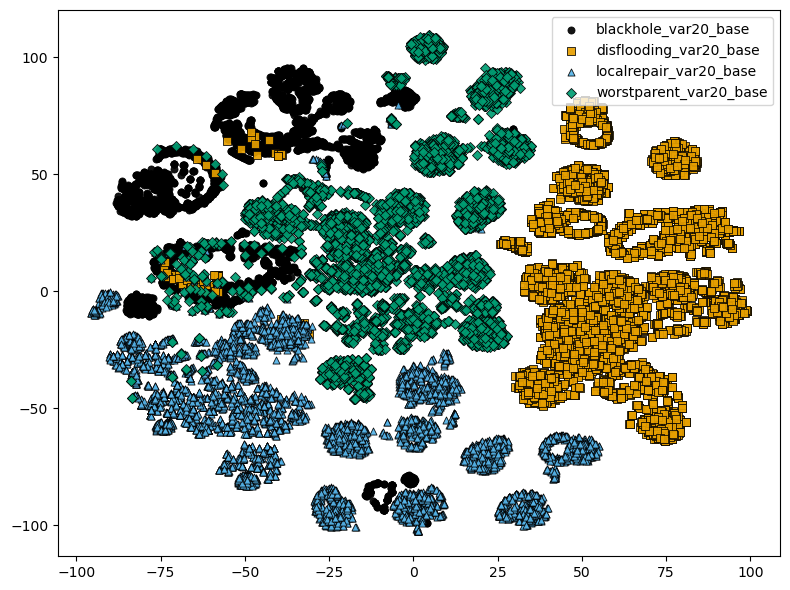

In [10]:
# === Color-blind–friendly t-SNE scatter (label=1, up to 4 domains) ===
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

%matplotlib inline

# Okabe–Ito palette (color-blind safe)
OKABE_ITO = [
    "#000000",  # black
    "#E69F00",  # orange
    "#56B4E9",  # sky blue
    "#009E73",  # bluish green
    "#F0E442",  # yellow
    "#0072B2",  # blue
    "#D55E00",  # vermillion
    "#CC79A7",  # reddish purple
]

# Distinct markers to reinforce categories beyond color
MARKERS = ["o", "s", "^", "D", "P", "X", "*", "v"]

@torch.no_grad()
def collect_features_from_loader(loader, device=None, max_samples=3000):
    if device is None:
        device = "cuda" if torch.cuda.is_available() else "cpu"
    X_list, y_list, n = [], [], 0
    for batch in loader:
        x, y = (batch[0], batch[1]) if isinstance(batch, (list,tuple)) else (batch["x"], batch["y"])
        x = x.to(device)
        # Handle shapes: [B,1,F] -> [B,F], [B,T,F] -> mean over time
        if x.ndim == 3:
            B, T, F = x.shape
            x = x.squeeze(1) if T == 1 else x.mean(dim=1)
        elif x.ndim == 1:
            x = x.unsqueeze(0)
        X_list.append(x.detach().cpu().numpy())

        y_np = y.detach().cpu().numpy() if isinstance(y, torch.Tensor) else np.asarray(y)
        if y_np.ndim == 2 and y_np.shape[1] > 1:
            y_np = y_np.argmax(axis=1)
        y_list.append(np.squeeze(y_np))

        n += x.shape[0]
        if n >= max_samples:
            break

    X = np.vstack(X_list)
    y = np.concatenate(y_list)
    if X.shape[0] > max_samples:
        X, y = X[:max_samples], y[:max_samples]
    return X, y


def collect_label_across_domains(loaders, keys, label=1, device="cpu", max_per_domain=2000):
    X_list, dom_list, kept = [], [], []
    for idx, k in enumerate(keys):
        X, y = collect_features_from_loader(loaders[k], device=device, max_samples=max_per_domain)
        mask = (np.squeeze(y) == label)
        Xf = X[mask]
        if Xf.size == 0:
            continue
        X_list.append(Xf)
        dom_list.append(np.full(Xf.shape[0], len(kept), dtype=int))
        kept.append(k)
    if not X_list:
        raise ValueError(f"No domains contained label={label}")
    return np.vstack(X_list), np.concatenate(dom_list), kept


def plot_tsne_scatter_colorblind(Z, domain_labels, domain_names=None,
                                 point_size=26, alpha=0.9, title="",
                                 edgecolor="black", linewidth=0.6):
    groups = np.unique(domain_labels)
    labels = domain_names if domain_names else [f"Domain {g}" for g in groups]

    plt.figure(figsize=(8, 6))
    for i, g in enumerate(groups):
        m = (domain_labels == g)
        pts = Z[m]
        color = OKABE_ITO[i % len(OKABE_ITO)]
        marker = MARKERS[i % len(MARKERS)]
        # Using both color + marker + edge outline for accessibility
        plt.scatter(
            pts[:, 0], pts[:, 1],
            s=point_size, c=color, marker=marker,
            edgecolors=edgecolor, linewidths=linewidth, alpha=alpha,
            label=labels[i]
        )

    # Improve readability
    plt.legend( loc="best", frameon=True)
    # plt.title(title)
    # plt.xlabel("t-SNE 1")
    #plt.ylabel("t-SNE 2")
    plt.tight_layout()
    plt.show()


# ====== RUN ======
substring = "var20_base"  # filter substring for your domain keys
candidate_keys = [k for k in train_domains_loader.keys() if substring in k]

# Collect only label==1
X_all, dom_labels, kept_keys = collect_label_across_domains(
    train_domains_loader, candidate_keys, label=1, device="cpu", max_per_domain=20000
)

# Keep up to 4 domains
uniq_ids = np.unique(dom_labels)[:4]
mask = np.isin(dom_labels, uniq_ids)
X_all = X_all[mask]
dom_labels = dom_labels[mask]
kept_names = [kept_keys[i] for i in uniq_ids]

# t-SNE
Xs = StandardScaler().fit_transform(X_all)
perp = max(5, min(30, (Xs.shape[0]-1)//3))
Z = TSNE(n_components=2, init="pca", learning_rate="auto",
         perplexity=perp, random_state=42).fit_transform(Xs)

# Plot (color-blind-friendly)
plot_tsne_scatter_colorblind(
    Z, dom_labels, domain_names=kept_names,
    point_size=26, alpha=0.92,
    title=f"t-SNE scatter (label=1) — {substring}"
)


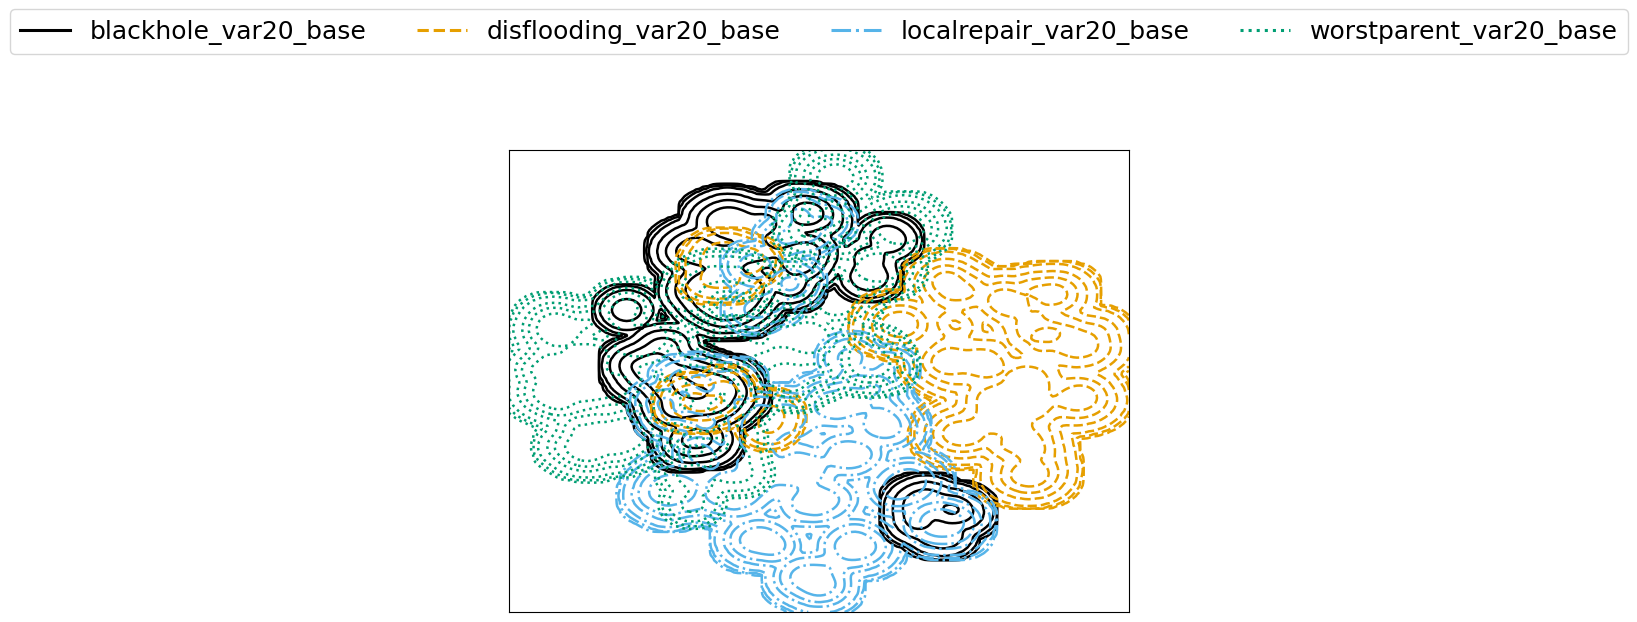

In [11]:
# =========================
# t-SNE CONTOUR-ONLY PLOT (label==1) — color-blind friendly
# =========================
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

%matplotlib inline

# -----------------
# USER CONTROLS
# -----------------
SUBSTRING = "var20_base"      # filter keys by this substring
POS_LABEL = 1                 # only plot this label
MAX_PER_DOMAIN = 20000      # cap per-domain samples gathered
KEEP_DOMAINS = 4              # compare up to N domains

# t-SNE smoothness (tweak if needed)
TSNE_PERPLEXITY_MAX = 50
TSNE_ITER = 2000
TSNE_EARLY_EXAGG = 8.0

# Contour grid / smoothing / levels
GRID_BINS = 180               # resolution of the 2D histogram grid
SMOOTH_SIGMA = 2.2            # Gaussian smoothing for contours (requires SciPy; safe if missing)
LEVEL_PERCENTILES = (5, 10, 20, 40, 60, 80)  # contour levels as density percentiles

# Legend placement (top)
LEGEND_NCOL = 4               # columns in legend
LEGEND_X = 0.5                # 0=left, 0.5=center, 1=right
LEGEND_Y = 1.18               # height above axes

# -----------------
# Color-blind palette + line styles
# -----------------
OKABE_ITO = [
    "#000000",  # black
    "#E69F00",  # orange
    "#56B4E9",  # sky blue
    "#009E73",  # bluish green
    "#F0E442",  # yellow
    "#0072B2",  # blue
    "#D55E00",  # vermillion
    "#CC79A7",  # reddish purple
]
LINESTYLES = ["solid", "dashed", "dashdot", "dotted", (0,(5,1,1,1)), (0,(3,1,1,1))]

# Try to import smoothing; fall back gracefully
try:
    from scipy.ndimage import gaussian_filter
    _HAS_SCIPY = True
except Exception:
    _HAS_SCIPY = False

# -----------------
# Data helpers
# -----------------
@torch.no_grad()
def collect_features_from_loader(loader, device=None, max_samples=3000):
    """Return X(N,D), y(N,) from a DataLoader; handles [B,1,F] or [B,T,F]."""
    if device is None:
        device = "cuda" if torch.cuda.is_available() else "cpu"
    X_list, y_list, n = [], [], 0
    for batch in loader:
        x, y = (batch[0], batch[1]) if isinstance(batch, (list, tuple)) else (batch["x"], batch["y"])
        x = x.to(device)
        if x.ndim == 3:
            B, T, F = x.shape
            x = x.squeeze(1) if T == 1 else x.mean(dim=1)
        elif x.ndim == 1:
            x = x.unsqueeze(0)
        X_list.append(x.detach().cpu().numpy())

        y_np = y.detach().cpu().numpy() if isinstance(y, torch.Tensor) else np.asarray(y)
        if y_np.ndim == 2 and y_np.shape[1] > 1:
            y_np = y_np.argmax(axis=1)
        y_list.append(np.squeeze(y_np))

        n += x.shape[0]
        if n >= max_samples:
            break

    if not X_list:
        raise ValueError("No data collected from loader.")
    X = np.vstack(X_list)
    y = np.concatenate(y_list)
    if X.shape[0] > max_samples:
        X, y = X[:max_samples], y[:max_samples]
    return X, y


def collect_label_across_domains(loaders, keys, label=1, device="cpu", max_per_domain=2000):
    """Collect features with given label across domains; skip domains without matches."""
    X_list, dom_list, kept = [], [], []
    for k in keys:
        X, y = collect_features_from_loader(loaders[k], device=device, max_samples=max_per_domain)
        y = np.squeeze(y)
        mask = (y == label) if y.dtype.kind in {"i","u"} else np.isclose(y.astype(float), float(label))
        Xf = X[mask]
        if Xf.size == 0:
            continue
        X_list.append(Xf)
        dom_list.append(np.full(Xf.shape[0], len(kept), dtype=int))
        kept.append(k)
    if not X_list:
        raise ValueError(f"No domains contained label={label}.")
    return np.vstack(X_list), np.concatenate(dom_list), kept

# -----------------
# Contour plotting (NO FILL)
# -----------------
def plot_tsne_contours_only(Z, group_labels, group_names=None,
                            bins=180, sigma=2.2, level_percentiles=(5,10,20,40,60,80),
                            linewidth=1.6):
    """
    Draw contour *lines only* (no shades) per group on a shared grid.
    Uses Okabe–Ito colors and distinct line styles.
    """
    x, y = Z[:, 0], Z[:, 1]
    groups = np.unique(group_labels)
    labels = group_names if group_names else [f"Domain {g}" for g in groups]

    # common bounds across all domains so contours align nicely
    pad_x = 0.05 * (x.max() - x.min() + 1e-6)
    pad_y = 0.05 * (y.max() - y.min() + 1e-6)
    xmin, xmax = x.min() - pad_x, x.max() + pad_x
    ymin, ymax = y.min() - pad_y, y.max() + pad_y

    plt.figure(figsize=(8, 6))

    # draw contours per group
    for i, g in enumerate(groups):
        m = (group_labels == g)
        H, xe, ye = np.histogram2d(
            x[m], y[m],
            bins=bins,
            range=[[xmin, xmax], [ymin, ymax]],
            density=True
        )
        if _HAS_SCIPY and sigma is not None and sigma > 0:
            H = gaussian_filter(H, sigma=sigma)

        # compute contour levels from non-zero density percentiles
        nz = H[H > 0]
        if nz.size == 0:
            continue
        levels = np.percentile(nz, level_percentiles)

        Xc = 0.5 * (xe[:-1] + xe[1:])
        Yc = 0.5 * (ye[:-1] + ye[1:])

        color = OKABE_ITO[i % len(OKABE_ITO)]
        ls = LINESTYLES[i % len(LINESTYLES)]
        cs = plt.contour(
            Xc, Yc, H.T,
            levels=levels,
            colors=[color],
            linestyles=ls,
            linewidths=linewidth,
            antialiased=True
        )

    # Build a legend with proxy lines (one per domain)
    from matplotlib.lines import Line2D
    handles = [
        Line2D([0], [0],
               color=OKABE_ITO[i % len(OKABE_ITO)],
               linestyle=LINESTYLES[i % len(LINESTYLES)],
               linewidth=2.2,
               label=labels[i])
        for i in range(len(groups))
    ]

    # Legend ABOVE the plot (adjust position/columns via controls)
    plt.legend(
        handles=handles,
        loc="lower center",
        bbox_to_anchor=(LEGEND_X, LEGEND_Y),
        ncol=min(LEGEND_NCOL, len(handles)),
        frameon=True,
        fontsize=18
    )

    # axes labels optional
    # plt.xlabel("t-SNE 1"); plt.ylabel("t-SNE 2")
    plt.xticks([])  
    plt.yticks([])           
    plt.tight_layout()
    plt.show()

# -----------------
# RUN
# -----------------
# 1) pick domains by substring
candidate_keys = [k for k in train_domains_loader.keys() if SUBSTRING in k]

# 2) collect only positives
X_all, dom_labels, kept_keys = collect_label_across_domains(
    train_domains_loader, candidate_keys, label=POS_LABEL, device="cpu", max_per_domain=MAX_PER_DOMAIN
)

# 3) keep first N domains
uniq_ids = np.unique(dom_labels)[:KEEP_DOMAINS]
mask = np.isin(dom_labels, uniq_ids)
X_all = X_all[mask]
dom_labels = dom_labels[mask]
kept_names = [kept_keys[i] for i in uniq_ids]

# 4) t-SNE with smoother defaults
Xs = StandardScaler().fit_transform(X_all)
perp = max(5, min(TSNE_PERPLEXITY_MAX, (Xs.shape[0]-1)//3))
Z = TSNE(
    n_components=2,
    init="pca",
    learning_rate="auto",
    perplexity=perp,
    early_exaggeration=TSNE_EARLY_EXAGG,
    n_iter=TSNE_ITER,
    n_iter_without_progress=400,
    angle=0.5,
    random_state=42
).fit_transform(Xs)

# 5) contour-only plot (no shades, no points)
plot_tsne_contours_only(
    Z, dom_labels,
    group_names=kept_names,
    bins=GRID_BINS,
    sigma=SMOOTH_SIGMA,
    level_percentiles=LEVEL_PERCENTILES,
    linewidth=1.8
)


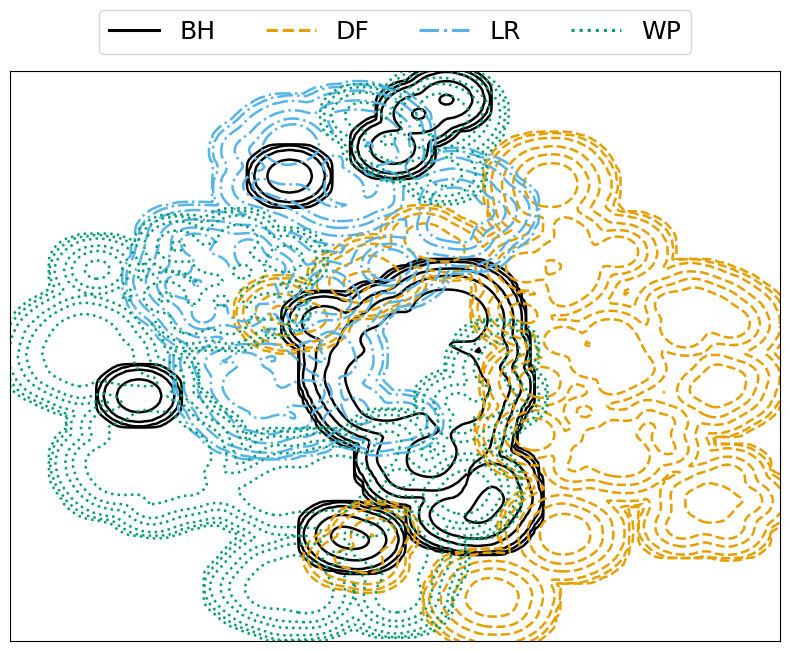

In [70]:
# =========================
# t-SNE CONTOUR-ONLY PLOT (label==1) — color-blind friendly
# With: figure-level draggable legend (manual X/Y/cols/size) + no x-ticks
# =========================
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

%matplotlib inline

# -----------------
# USER CONTROLS
# -----------------
SUBSTRING = "var5_base"      # filter keys by this substring
POS_LABEL = 1                 # only plot this label
MAX_PER_DOMAIN = 20000        # cap per-domain samples gathered
KEEP_DOMAINS = 4              # compare up to N domains

# t-SNE smoothness
TSNE_PERPLEXITY_MAX = 50
TSNE_ITER = 2000
TSNE_EARLY_EXAGG = 8.0

# Contour grid / smoothing / levels
GRID_BINS = 180               # resolution of the 2D histogram grid
SMOOTH_SIGMA = 2.2            # Gaussian smoothing (requires SciPy; falls back if missing)
LEVEL_PERCENTILES = (5, 10, 20, 40, 60, 80)  # contour levels as density percentiles
LINEWIDTH = 1.8               # contour line width

# Legend (figure-level, draggable)
LEGEND_X = 0.50               # 0..1 across figure width (0=left, 1=right)
LEGEND_Y = 1.04               # 0..1 across figure height (1 = top edge)
LEGEND_NCOL = 4               # number of legend columns
LEGEND_FONTSIZE = 18          # legend font size

# -----------------
# Color-blind palette + line styles
# -----------------
OKABE_ITO = [
    "#000000",  # black
    "#E69F00",  # orange
    "#56B4E9",  # sky blue
    "#009E73",  # bluish green
    "#F0E442",  # yellow
    "#0072B2",  # blue
    "#D55E00",  # vermillion
    "#CC79A7",  # reddish purple
]
LINESTYLES = ["solid", "dashed", "dashdot", "dotted", (0,(5,1,1,1)), (0,(3,1,1,1))]

# Try smoothing; fall back gracefully if SciPy is missing
try:
    from scipy.ndimage import gaussian_filter
    _HAS_SCIPY = True
except Exception:
    _HAS_SCIPY = False

# -----------------
# Data helpers
# -----------------
@torch.no_grad()
def collect_features_from_loader(loader, device=None, max_samples=3000):
    """Return X(N,D), y(N,) from a DataLoader; handles [B,1,F] or [B,T,F]."""
    if device is None:
        device = "cuda" if torch.cuda.is_available() else "cpu"
    X_list, y_list, n = [], [], 0
    for batch in loader:
        x, y = (batch[0], batch[1]) if isinstance(batch, (list, tuple)) else (batch["x"], batch["y"])
        x = x.to(device)
        if x.ndim == 3:
            B, T, F = x.shape
            x = x.squeeze(1) if T == 1 else x.mean(dim=1)
        elif x.ndim == 1:
            x = x.unsqueeze(0)
        X_list.append(x.detach().cpu().numpy())

        y_np = y.detach().cpu().numpy() if isinstance(y, torch.Tensor) else np.asarray(y)
        if y_np.ndim == 2 and y_np.shape[1] > 1:
            y_np = y_np.argmax(axis=1)
        y_list.append(np.squeeze(y_np))

        n += x.shape[0]
        if n >= max_samples:
            break

    if not X_list:
        raise ValueError("No data collected from loader.")
    X = np.vstack(X_list)
    y = np.concatenate(y_list)
    if X.shape[0] > max_samples:
        X, y = X[:max_samples], y[:max_samples]
    return X, y


def collect_label_across_domains(loaders, keys, label=1, device="cpu", max_per_domain=2000):
    """Collect features with given label across domains; skip domains without matches."""
    X_list, dom_list, kept = [], [], []
    for k in keys:
        X, y = collect_features_from_loader(loaders[k], device=device, max_samples=max_per_domain)
        y = np.squeeze(y)
        mask = (y == label) if y.dtype.kind in {"i","u"} else np.isclose(y.astype(float), float(label))
        Xf = X[mask]
        if Xf.size == 0:
            continue
        X_list.append(Xf)
        dom_list.append(np.full(Xf.shape[0], len(kept), dtype=int))
        kept.append(k)
    if not X_list:
        raise ValueError(f"No domains contained label={label}.")
    return np.vstack(X_list), np.concatenate(dom_list), kept

# -----------------
# Contour plotting (NO FILL) + legend + remove x-ticks
# -----------------
def plot_tsne_contours_only(Z, group_labels, group_names=None,
                            bins=180, sigma=2.2, level_percentiles=(5,10,20,40,60,80),
                            linewidth=1.8,
                            legend_x=0.5, legend_y=0.98, legend_ncol=4, legend_fontsize=16):
    """
    Draw contour *lines only* (no shades) per group on a shared grid.
    Uses Okabe–Ito colors and distinct line styles.
    Adds a figure-level, draggable legend positioned manually.
    Removes x-ticks.
    """
    x, y = Z[:, 0], Z[:, 1]
    groups = np.unique(group_labels)
    labels = group_names if group_names else [f"Domain {g}" for g in groups]

    # common bounds across all domains so contours align nicely
    pad_x = 0.05 * (x.max() - x.min() + 1e-6)
    pad_y = 0.05 * (y.max() - y.min() + 1e-6)
    xmin, xmax = x.min() - pad_x, x.max() + pad_x
    ymin, ymax = y.min() - pad_y, y.max() + pad_y

    fig, ax = plt.subplots(figsize=(8, 6))

    # draw contours per group
    for i, g in enumerate(groups):
        m = (group_labels == g)
        H, xe, ye = np.histogram2d(
            x[m], y[m],
            bins=bins,
            range=[[xmin, xmax], [ymin, ymax]],
            density=True
        )
        if _HAS_SCIPY and sigma is not None and sigma > 0:
            H = gaussian_filter(H, sigma=sigma)

        nz = H[H > 0]
        if nz.size == 0:
            continue
        levels = np.percentile(nz, level_percentiles)

        Xc = 0.5 * (xe[:-1] + xe[1:])
        Yc = 0.5 * (ye[:-1] + ye[1:])

        color = OKABE_ITO[i % len(OKABE_ITO)]
        ls = LINESTYLES[i % len(LINESTYLES)]
        ax.contour(
            Xc, Yc, H.T,
            levels=levels,
            colors=[color],
            linestyles=ls,
            linewidths=linewidth,
            antialiased=True
        )

    # Build legend proxy handles
    from matplotlib.lines import Line2D
    handles = [
        Line2D([0], [0],
               color=OKABE_ITO[i % len(OKABE_ITO)],
               linestyle=LINESTYLES[i % len(LINESTYLES)],
               linewidth=2.2,
               label=labels[i])
        for i in range(len(groups))
    ]

    # Figure-level, draggable legend (manual position/cols/size)
    legend = fig.legend(
        handles=handles,
        loc="center",
        bbox_to_anchor=(legend_x, legend_y),
        ncol=min(legend_ncol, len(handles)),
        frameon=True,
        fontsize=legend_fontsize,
        bbox_transform=fig.transFigure
    )
    legend.set_draggable(True)

    # Remove x-ticks (locations and labels)
    ax.set_xticks([])
    ax.set_xticklabels([])
    ax.tick_params(axis='x', which='both', length=0)
    ax.set_yticks([])
    ax.set_yticklabels([])

    # Optional: keep y-ticks; comment next three lines to remove y-ticks too
    # ax.set_yticks([])
    # ax.set_yticklabels([])
    # ax.tick_params(axis='y', which='both', length=0)

    plt.tight_layout()
    plt.show()
    return legend  # so you can adjust later if you want

def short_label(name: str) -> str:
    n = name.lower()
    if "blackhole" in n or "black_hole" in n or "bh" in n:
        return "BH"
    if "disflood" in n or "disflooding" in n or "df" in n:
        return "DF"
    if "worstparent" in n or "worst_parent" in n or "wp" in n:
        return "WP"
    if "localrepair" in n or "local_repair" in n or "lr" in n:
        return "LR"
    # fallback: keep original if none matched
    return name
# -----------------
# RUN
# -----------------
# 1) pick domains by substring
candidate_keys = [k for k in train_domains_loader.keys() if SUBSTRING in k]

# 2) collect only positives
X_all, dom_labels, kept_keys = collect_label_across_domains(
    train_domains_loader, candidate_keys, label=POS_LABEL, device="cpu", max_per_domain=MAX_PER_DOMAIN
)

# 3) keep first N domains
uniq_ids = np.unique(dom_labels)[:KEEP_DOMAINS]
mask = np.isin(dom_labels, uniq_ids)
X_all = X_all[mask]
dom_labels = dom_labels[mask]
kept_names = [kept_keys[i] for i in uniq_ids]

# 4) t-SNE
Xs = StandardScaler().fit_transform(X_all)
perp = max(5, min(TSNE_PERPLEXITY_MAX, (Xs.shape[0]-1)//3))
Z = TSNE(
    n_components=2,
    init="pca",
    learning_rate="auto",
    perplexity=perp,
    early_exaggeration=TSNE_EARLY_EXAGG,
    n_iter=TSNE_ITER,
    n_iter_without_progress=400,
    angle=0.5,
    random_state=42
).fit_transform(Xs)

display_names = [short_label(k) for k in kept_names]

legend = plot_tsne_contours_only(
    Z, dom_labels,
    group_names=display_names,        # <- use BH / DF / WP / LR here
    bins=GRID_BINS,
    sigma=SMOOTH_SIGMA,
    level_percentiles=LEVEL_PERCENTILES,
    linewidth=LINEWIDTH,
    legend_x=LEGEND_X, legend_y=LEGEND_Y,
    legend_ncol=LEGEND_NCOL, legend_fontsize=LEGEND_FONTSIZE
)


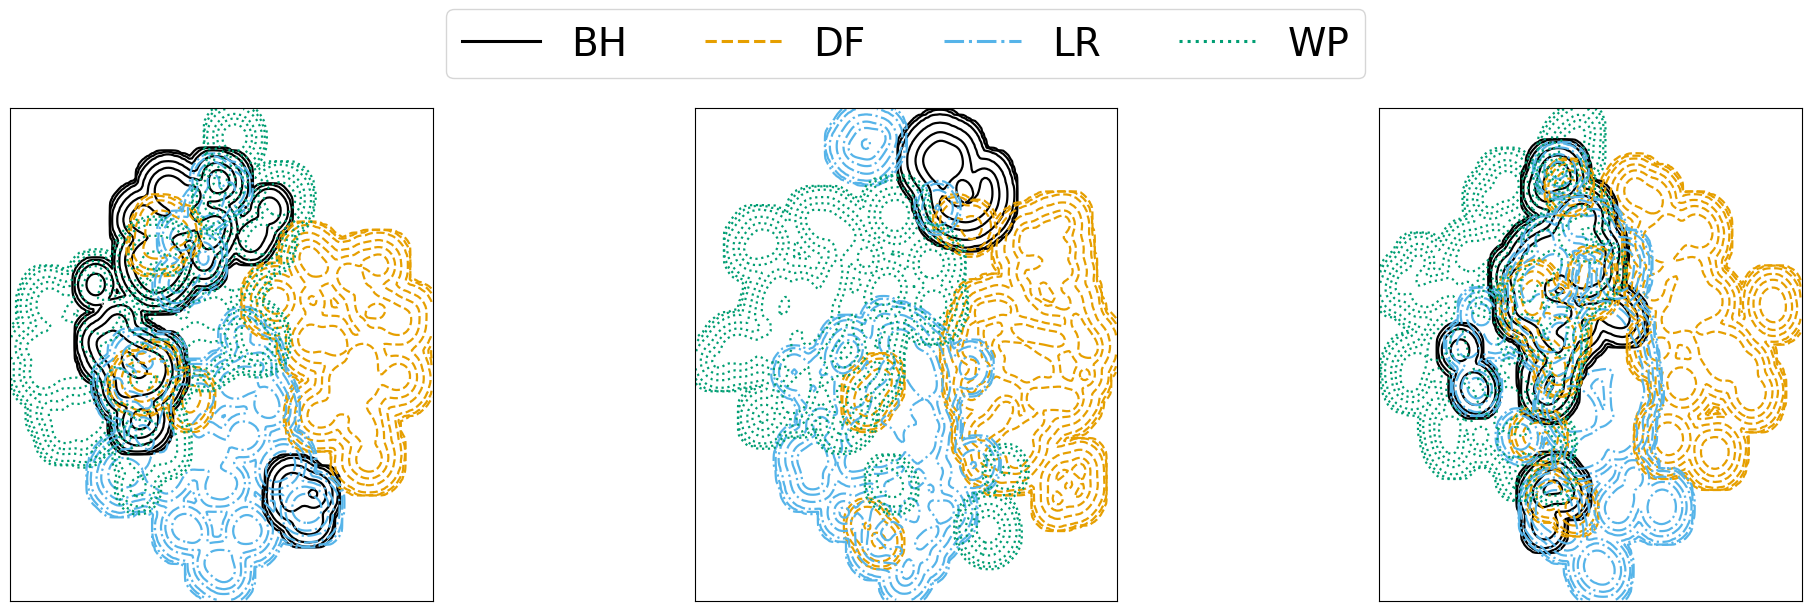

In [73]:
# =========================
# Three side-by-side t-SNE contour plots (label==1)
# Only the MIDDLE panel shows the legend
# Panels: var20_base | var20_oo | var20_dec
# =========================
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

%matplotlib inline

# ---------- USER KNOBS ----------
POS_LABEL = 1
MAX_PER_DOMAIN = 20000          # cap per domain
TSNE_PERPLEXITY_MAX = 50
TSNE_ITER = 2000
TSNE_EARLY_EXAGG = 8.0
GRID_BINS = 180
SMOOTH_SIGMA = 2.2              # if SciPy present; otherwise unsmoothed
LEVEL_PERCENTILES = (5, 10, 20, 40, 60, 80)
LINEWIDTH = 1.6

# Legend (only for middle axis)
LEGEND_NCOL = 4
LEGEND_FONTSIZE = 28
LEGEND_LOC = "lower center"         # position relative to middle axis
LEGEND_BBOX = (0.5, 1.02)           # (x,y) above middle axis (0.5=center)

# ---------- Styles & mapping ----------
OKABE_ITO = {
    "BH": "#000000",   # black
    "DF": "#E69F00",   # orange
    "LR": "#56B4E9",   # sky blue
    "WP": "#009E73",   # bluish green
}
LINESTYLES = {
    "BH": "solid",
    "DF": "dashed",
    "LR": "dashdot",
    "WP": "dotted",
}
TYPE_ORDER = ["BH", "DF", "LR", "WP"]  # consistent order

def short_label(name: str) -> str:
    n = name.lower()
    if "blackhole" in n or "black_hole" in n or n.startswith("bh"): return "BH"
    if "disflood" in n or "dis_flood" in n or n.startswith("df"):  return "DF"
    if "localrepair" in n or "local_repair" in n or n.startswith("lr"): return "LR"
    if "worstparent" in n or "worst_parent" in n or n.startswith("wp"): return "WP"
    return "UNK"

# smoothing (optional)
try:
    from scipy.ndimage import gaussian_filter
    _HAS_SCIPY = True
except Exception:
    _HAS_SCIPY = False

# ---------- Data helpers ----------
@torch.no_grad()
def collect_features_from_loader(loader, device=None, max_samples=3000):
    if device is None:
        device = "cuda" if torch.cuda.is_available() else "cpu"
    X_list, y_list, n = [], [], 0
    for batch in loader:
        x, y = (batch[0], batch[1]) if isinstance(batch, (list, tuple)) else (batch["x"], batch["y"])
        x = x.to(device)
        if x.ndim == 3:
            B, T, F = x.shape
            x = x.squeeze(1) if T == 1 else x.mean(dim=1)
        elif x.ndim == 1:
            x = x.unsqueeze(0)
        X_list.append(x.detach().cpu().numpy())
        y_np = y.detach().cpu().numpy() if isinstance(y, torch.Tensor) else np.asarray(y)
        if y_np.ndim == 2 and y_np.shape[1] > 1:
            y_np = y_np.argmax(axis=1)
        y_list.append(np.squeeze(y_np))
        n += x.shape[0]
        if n >= max_samples:
            break
    X = np.vstack(X_list)
    y = np.concatenate(y_list)
    if X.shape[0] > max_samples:
        X, y = X[:max_samples], y[:max_samples]
    return X, y

def collect_by_type(loaders, substring, label=1, device="cpu", max_per_domain=20000):
    """
    Returns X_all (N,D), type_idx (N,), present_types (list of codes in TYPE_ORDER order)
    Only keeps domains whose key contains `substring` and samples with given label.
    """
    X_chunks = {t: [] for t in TYPE_ORDER}
    for k in [kk for kk in loaders.keys() if substring in kk]:
        t = short_label(k)
        if t not in TYPE_ORDER:
            continue
        X, y = collect_features_from_loader(loaders[k], device=device, max_samples=max_per_domain)
        y = np.squeeze(y)
        mask = (y == label) if y.dtype.kind in {"i","u"} else np.isclose(y.astype(float), float(label))
        if np.any(mask):
            X_chunks[t].append(X[mask])

    present = [t for t in TYPE_ORDER if len(X_chunks[t]) > 0]
    if not present:
        raise ValueError(f"No positives found for substring '{substring}'.")
    X_all = np.vstack([np.vstack(X_chunks[t]) for t in present])
    type_idx = np.concatenate([np.full(sum(x.shape[0] for x in X_chunks[t]), present.index(t), dtype=int)
                               for t in present])
    return X_all, type_idx, present

# ---------- Plot onto a given Axes ----------
def plot_contours_on_ax(ax, Z, type_idx, present_types):
    x, y = Z[:, 0], Z[:, 1]
    pad_x = 0.05 * (x.max() - x.min() + 1e-6)
    pad_y = 0.05 * (y.max() - y.min() + 1e-6)
    xmin, xmax = x.min() - pad_x, x.max() + pad_x
    ymin, ymax = y.min() - pad_y, y.max() + pad_y

    for i, t in enumerate(present_types):
        m = (type_idx == i)
        H, xe, ye = np.histogram2d(
            x[m], y[m], bins=GRID_BINS,
            range=[[xmin, xmax], [ymin, ymax]],
            density=True
        )
        if _HAS_SCIPY and SMOOTH_SIGMA and SMOOTH_SIGMA > 0:
            H = gaussian_filter(H, sigma=SMOOTH_SIGMA)

        nz = H[H > 0]
        if nz.size == 0:
            continue
        levels = np.percentile(nz, LEVEL_PERCENTILES)
        Xc = 0.5 * (xe[:-1] + xe[1:])
        Yc = 0.5 * (ye[:-1] + ye[1:])

        ax.contour(
            Xc, Yc, H.T,
            levels=levels,
            colors=[OKABE_ITO[t]],
            linestyles=LINESTYLES[t],
            linewidths=LINEWIDTH,
            antialiased=True
        )

    # Clean look (no ticks)
    ax.set_xticks([]); ax.set_yticks([])
    ax.set_xlim(xmin, xmax); ax.set_ylim(ymin, ymax)

# ---------- RUN (three panels) ----------
substrings = ["var20_base", "var20_oo", "var20_dec"]
fig, axes = plt.subplots(1, 3, figsize=(18, 6), constrained_layout=True)

present_types_middle = None  # we'll store what's present in the middle panel for the legend

for ax, sub in zip(axes, substrings):
    # 1) gather positives for this substring
    X_all, t_idx, present_types = collect_by_type(
        train_domains_loader, substring=sub, label=POS_LABEL, device="cpu", max_per_domain=MAX_PER_DOMAIN
    )
    # 2) t-SNE
    Xs = StandardScaler().fit_transform(X_all)
    perp = max(5, min(TSNE_PERPLEXITY_MAX, (Xs.shape[0]-1)//3))
    Z = TSNE(
        n_components=2, init="pca", learning_rate="auto",
        perplexity=perp, early_exaggeration=TSNE_EARLY_EXAGG,
        n_iter=TSNE_ITER, n_iter_without_progress=400,
        angle=0.5, random_state=42
    ).fit_transform(Xs)
    # 3) plot
    plot_contours_on_ax(ax, Z, t_idx, present_types)
    # ax.set_title(sub, fontsize=13)

    if sub == "var20_oo":
        present_types_middle = present_types

# ---------- Legend ONLY on the middle axis ----------
from matplotlib.lines import Line2D
if present_types_middle is None:
    present_types_middle = []  # safety, but should be set above

handles = [
    Line2D([0], [0],
           color=OKABE_ITO[t],
           linestyle=LINESTYLES[t],
           linewidth=2.2,
           label=t)
    for t in present_types_middle
]

axes[1].legend(
    handles=handles,
    loc=LEGEND_LOC,
    bbox_to_anchor=LEGEND_BBOX,   # above the middle axis
    ncol=min(LEGEND_NCOL, len(handles)),
    frameon=True,
    fontsize=LEGEND_FONTSIZE
)
# If you’re on an interactive backend and want to drag this legend instead:
# leg = axes[1].legend(...)
# leg.set_draggable(True)

plt.show()
